In [67]:
import os, yaml, sys
from sklearn.cluster import KMeans
import torch
ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from parallel.parallel_funcs import print_wise

[Tiziano-Causin.local:89491] shmem: mmap: an error occurred while determining whether or not /var/folders/nw/yf48zdjj1m5012281wx_pzhc0000gn/T//ompi.Tiziano-Causin.501/jf.0/4062314496/sm_segment.Tiziano-Causin.501.f2220000.0 could be created.


In [68]:
def multistage_kmeans(
    X,
    n_clusters_per_level,
    **kmeans_args
):
    """
    Perform multistage KMeans clustering.

    Args:
        X (torch.Tensor): Input data on CUDA.
        n_clusters_per_level (list): List of cluster counts for each stage.
        kmeans_args (dict, optional): Arguments to pass to kmeans_gpu.

    Returns:
        centers_list (list): List of centers at each stage.
    """
    if kmeans_args is None:
        kmeans_args = {
            'init': 'k-means++',
            'max_iter': 10000,
            'tol': 1e-6,
            'n_init': 20
        }


    centers_list = []
    print(f"Levels: {len(n_clusters_per_level)} | Clusters per level: {n_clusters_per_level}")
    for level, size in enumerate(n_clusters_per_level):
        print_wise(f"\n--- Level {level+1}/{len(n_clusters_per_level)}: Clustering into {size} clusters ---")
        if level == 0:
            data = X
        else:
            data = centers_list[level - 1]
        print_wise(f"  Data shape: {data.shape}")
        kmeans = KMeans(
            n_clusters=size,
            **kmeans_args
        )
        kmeans.fit(data.cpu().numpy())  # sklearn needs numpy, not torch

        centers = torch.tensor(kmeans.cluster_centers_, device=data.device)
        labels = torch.tensor(kmeans.labels_, device=data.device)
        inertia = kmeans.inertia_
        n_iter = kmeans.n_iter_
        print(f"  Done: {size} centers, inertia={inertia:.2f}, iterations={n_iter}")
        centers_list.append(centers)
    return centers_list

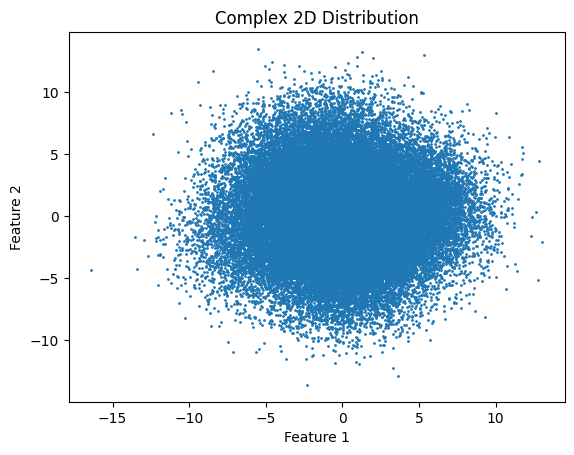

In [72]:

from sklearn.decomposition import PCA

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# generate a complex 2D distribution that mimickls realistic data
# with multiple clusters and some noise
def generate_complex_distribution(n_samples=10000, n_features=2, n_clusters=5, device='cuda'):
    """Generate a more realistic, messy N-dimensional distribution with multiple, highly overlapping clusters and noise."""
    centers = torch.randn(n_clusters, n_features, device=device) * 1  # bring centers closer for more overlap
    samples = []
    for i, center in enumerate(centers):
        # Increase spread for more overlap
        cov_diag = (2.5 + torch.rand(n_features, device=device) * 6)
        cov = torch.diag(cov_diag)
        # For N > 2, random rotation matrix is more complex; skip rotation for general N
        cluster_samples = torch.distributions.MultivariateNormal(center, cov).sample((n_samples // n_clusters,))
        samples.append(cluster_samples)
    X = torch.cat(samples, dim=0)
    # Add uniform noise
    noise = (torch.rand(int(0.05 * n_samples), n_features, device=device) - 0.5) * 1
    X = torch.cat([X, noise], dim=0)
    return X, centers

# plot the distribution
def plot_distribution(X):
    """Plot the 2D distribution."""
    import matplotlib.pyplot as plt

    if X.shape[1] > 2:
        X_cpu = X.cpu().numpy()
        X_pca = PCA(n_components=2).fit_transform(X_cpu)
        X = torch.from_numpy(X_pca)
    plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), s=1)
    plt.title("Complex 2D Distribution")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()


N_SAMPLES = 50000
N_FEATURES = 100
N_CLUSTERS = 30
# plot a complex distribution
X, centers_gt = generate_complex_distribution(n_samples=N_SAMPLES, n_features=N_FEATURES, n_clusters=N_CLUSTERS, device=device)
plot_distribution(X)


In [74]:
X = X.to(device)
# do kmeans with n_clusters=35
max_n_clusters = N_SAMPLES//10
n_clusters_per_level = [max_n_clusters // (2 ** i) for i in range(5)]
centers = multistage_kmeans(X, n_clusters_per_level, init='k-means++', max_iter=100, tol=1e-3, n_init=10)

Levels: 5 | Clusters per level: [5000, 2500, 1250, 625, 312]
13:42:50 - 
--- Level 1/5: Clustering into 5000 clusters ---
13:42:50 -   Data shape: torch.Size([52480, 100])
  Done: 5000 centers, inertia=23003788.00, iterations=63
14:05:34 - 
--- Level 2/5: Clustering into 2500 clusters ---
14:05:34 -   Data shape: torch.Size([5000, 100])
  Done: 2500 centers, inertia=1261169.50, iterations=8
14:06:48 - 
--- Level 3/5: Clustering into 1250 clusters ---
14:06:48 -   Data shape: torch.Size([2500, 100])
  Done: 1250 centers, inertia=769260.19, iterations=7
14:07:22 - 
--- Level 4/5: Clustering into 625 clusters ---
14:07:22 -   Data shape: torch.Size([1250, 100])
  Done: 625 centers, inertia=415022.31, iterations=4
14:07:30 - 
--- Level 5/5: Clustering into 312 clusters ---
14:07:30 -   Data shape: torch.Size([625, 100])
  Done: 312 centers, inertia=218970.03, iterations=5


In [47]:
def plot_kmeans_clusters(X, centers, centers2=None):
    """Plot the KMeans clusters."""
    import matplotlib.pyplot as plt

    if X.shape[1] > 2:
        X_cpu = X.cpu().numpy()
        pca = PCA(n_components=2).fit(X_cpu)
        X_pca = pca.transform(X_cpu)
        print(X_pca.shape)
        X = torch.from_numpy(X_pca)
        centers = torch.from_numpy(pca.transform(centers))
        if centers2 is not None:
            centers2 = torch.from_numpy(pca.transform(centers2.cpu().numpy()))
            
    #plt.scatter(X[:, 0], X[:, 1], c='k', s=1, cmap='viridis')
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50, marker='x')
    if centers2 is not None:
        plt.scatter(centers2[:, 0], centers2[:, 1], c='blue', s=50, marker='o')
    plt.title("KMeans Clusters")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.colorbar(label='Cluster Label')
    plt.show()

In [ ]:
import numpy as np

# X: (n_samples, n_features)
# centers: (n_clusters, n_features)

# compute squared distances (n_samples x n_clusters)
dists = np.linalg.norm(X[:, None, :] - centers[4][None, :, :], axis=2)

# assign cluster = index of nearest center
labels = np.argmin(dists, axis=1)

print(labels)  # for each datapoint, gives closest centroid index

In [ ]:
plot_kmeans_clusters(X, centers[4], show_labels=True)

In [70]:
def plot_kmeans_clusters(X, centers, show_labels=True):
    """Plot the KMeans clusters with optional point labels."""
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    import torch

    # PCA if needed
    if X.shape[1] > 2:
        X_cpu = X.cpu().numpy()
        pca = PCA(n_components=2).fit(X_cpu)
        X_pca = pca.transform(X_cpu)
        X = torch.from_numpy(X_pca)

        centers = torch.from_numpy(pca.transform(centers.cpu().numpy()))
        
    # compute labels (nearest centroid index for each point)
    dists = torch.cdist(X, centers)
    labels = torch.argmin(dists, dim=1).cpu().numpy()

    # plot points colored by cluster
    if show_labels:
        plt.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='tab10', alpha=0.7)
    else:
        plt.scatter(X[:, 0], X[:, 1], c='k', s=10, alpha=0.5)

    # plot centers
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=20, marker='x')
    plt.title("KMeans Clusters")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    if show_labels:
        plt.colorbar(label='Cluster Label')
    plt.show()